# Super-Resolution of Phantom Images with INRs (Demo)

Solves the INR training problem

$\min_\theta \|F_\Omega f_\theta - y\|_2^2 + \lambda R(\theta)$

where $f_\theta$ is an INR, $F_\Omega$ is a Fourier subsampling operator, $y$ is a vector low-pass Fourier measurements, and $R(\theta)$ is a (generalized) weight decay penalty.

This notebook is just for demonstration purposes. See the README on how to use the `run_exp.py` script and the provided configuration files in the /exp subfolder to reproduce the results in the paper.

### Load Packages

In [12]:
import torch
import numpy as np
import matplotlib.pylab as plt

### Set GPU device for torch

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load phantom data

note: x0 is a zero-filled IFFT recon onto 1024x1024 pixel grid from the *exact* Fourier coefficients of the phantom computed up to frequency cutoff K=127, whereas x00 is a rasterization of the phantom on 1024x1024 pixel grid. In particular, there will be some approximation error between the low-pass DFT coefficients of x00 and x0.

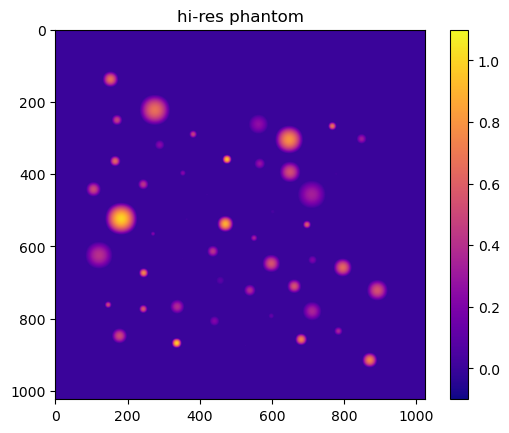

In [14]:
phantom_name = "DOTS"       # "dots" phantom
# phantom_name = "SL"         # Shepp-Logan phantom
# phantom_name = "PWC-BRAIN"  # piecewise constant brain MRI phantom
# phantom_name = "PWS-BRAIN"  # piecewise smooth brain MRI phantom

x0 = np.load("data/"+phantom_name+"_lowpass_1024.npy") #ideal low-pass version of phantom computed from *exact* fourier coefficients
x00 = np.load("data/"+phantom_name+"_rasterized_1024.npy") #hi-res rasterized phantom for reference

x0 = torch.from_numpy(x0).float().to(device)
x00 = torch.from_numpy(x00).float().to(device)

plt.imshow(x00.cpu(),vmin=-0.1,vmax=1.1,cmap="plasma")
plt.colorbar()
plt.title("hi-res phantom")
plt.show()


### extract low-pass Fourier data y, visualize zero-filled IFFT recon

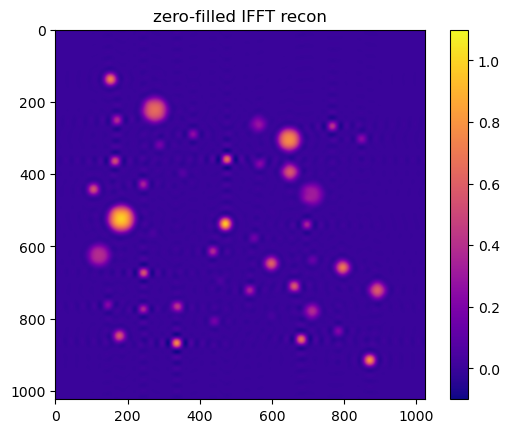

MSE of zero-filled IFFT recon: 2.233890e-04


In [47]:
from utils import get_fourier_sampling_mask

nx = 1024 #recon grid size
res = (nx,nx) #image resolution over which to perform FFTs
K = 32 #sampling frequency cutoff
mask = get_fourier_sampling_mask(nx,K)
mask = mask.to(device)

y = torch.fft.fft2(x0,norm="ortho")[mask]  #low-pass Fourier coefficients

x1 = torch.zeros(res, dtype=torch.complex64, device=device)
x1[mask] = y
x1 = torch.real(torch.fft.ifft2(x1,norm="ortho"))

plt.imshow(x1.cpu(),vmin=-0.1,vmax=1.1,cmap="plasma")
plt.colorbar()
plt.title("zero-filled IFFT recon")
plt.show()

MSE = torch.nn.MSELoss() #mean-squared error loss function
imgmse = MSE(x1,x00)
print(f"MSE of zero-filled IFFT recon: {imgmse.item():>4e}")

### Initialize shallow INR with Fourier features layer

define INR coordinates

In [48]:
from utils import get_coords

coords = get_coords(nx, range = (0,1), dim=2)
coords = coords.to(device) #tensor of coordinates in nx^2 coordinates in [0,1]^2

load INR, visualize initalization

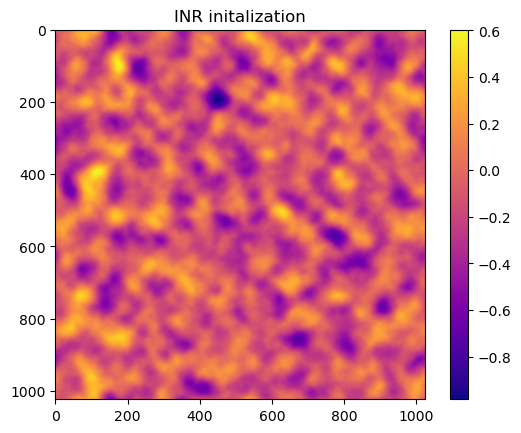

In [54]:
from utils import get_inr

#define shallow INR with Fourier features layer having gridded frequencies with max frequency K0 = 10, and width = 100, with "modified WD-I" type weight decay regularization enabled (use "reg_type":"std" for standard weight decay instead)
arch = "ffrelu_shallow"
arch_options = {"ff_freq":"gridded", "K0":10, "width":100, "reg_type":"mod1"}

torch.manual_seed(1) #set seed for reproducibility
inr = get_inr(arch,arch_options)
inr = inr.to(device)
vars = {"coords": coords, "res": res, "mask": mask}
inr.register(vars) #need to register extra vars for reg_type="mod1" or "mod2"; can skip this in other cases

with torch.no_grad():
    x = inr(coords).view(res)
    plt.imshow(x.cpu(),cmap="plasma")
    plt.colorbar()
    plt.title("INR initalization")
    plt.show()

### Train the INR

For speed, the INR is being trained for 25,000 epochs with a fixed learning rate. In the paper, the results are obtained using 50,000 epochs with a learning rate scheduler, which gives slightly more accurate reconstructions.

**Caution**: this cell will take ~30 minutes to run on an NVIDIA GeForce RTX 4090

iter: 100, loss: 9.087690e-01, DataMSE: 7.324806e-02, WDReg: 1.671042e+00, ImgMSE: 5.609819e-04
iter: 200, loss: 3.340023e-01, DataMSE: 6.610109e-02, WDReg: 5.358025e-01, ImgMSE: 5.320087e-04
iter: 300, loss: 2.169175e-01, DataMSE: 5.651028e-02, WDReg: 3.208144e-01, ImgMSE: 4.987512e-04
iter: 400, loss: 1.758347e-01, DataMSE: 4.469217e-02, WDReg: 2.622852e-01, ImgMSE: 4.549998e-04
iter: 500, loss: 1.539015e-01, DataMSE: 3.528088e-02, WDReg: 2.372413e-01, ImgMSE: 4.179781e-04
iter: 600, loss: 1.391681e-01, DataMSE: 2.834772e-02, WDReg: 2.216407e-01, ImgMSE: 3.894033e-04
iter: 700, loss: 1.276246e-01, DataMSE: 2.320847e-02, WDReg: 2.088323e-01, ImgMSE: 3.665192e-04
iter: 800, loss: 1.183485e-01, DataMSE: 1.945047e-02, WDReg: 1.977960e-01, ImgMSE: 3.483624e-04
iter: 900, loss: 1.104762e-01, DataMSE: 1.658827e-02, WDReg: 1.877759e-01, ImgMSE: 3.342262e-04
iter: 1000, loss: 1.033417e-01, DataMSE: 1.416444e-02, WDReg: 1.783545e-01, ImgMSE: 3.214049e-04
iter: 1100, loss: 9.720501e-02, DataMSE

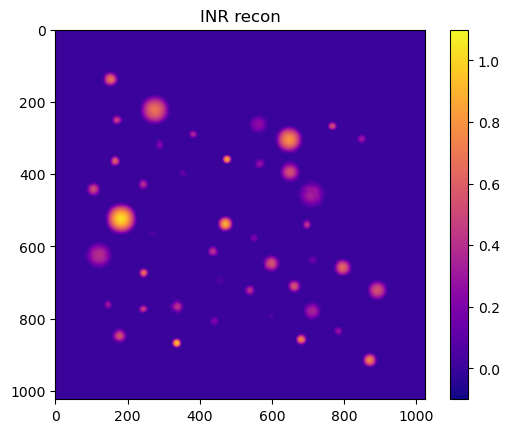

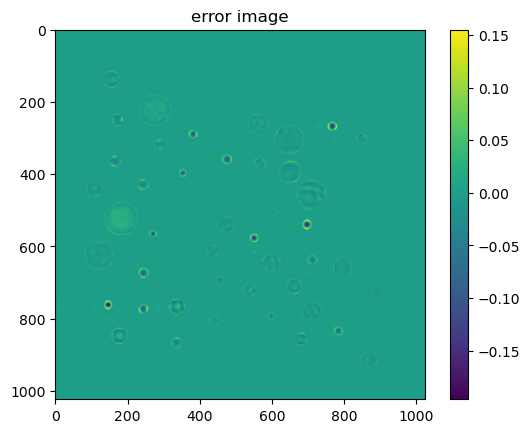

In [55]:
MSE = torch.nn.MSELoss() #mean-squared error loss function

optimizer = torch.optim.Adam(inr.parameters(),lr=0.001)

lam = 0.5 #WD regularization strength

epochs = 25000

for iter in range(epochs):
    optimizer.zero_grad()

    x = inr(coords).view(res)
    Ax = torch.fft.fft2(x,norm="ortho")[mask]
    mseloss = MSE(torch.real(Ax),torch.real(y))+MSE(torch.imag(Ax),torch.imag(y))
    wd_reg = inr.weight_decay()
    loss = mseloss + lam*wd_reg

    loss.backward()
    optimizer.step()

    # print metrics
    if iter % 100 == 99:
        with torch.no_grad():
            imgmse = MSE(x,x00)  #MSE with ground truth rasterized phantom
            print(f"iter: {iter+1}, loss: {loss.item():>4e}, DataMSE: {mseloss.item():>4e}, WDReg: {wd_reg.item():>4e}, ImgMSE: {imgmse.item():>4e}")

with torch.no_grad():
    x = inr(coords).view(res)

imgmse = MSE(x,x00)
print(f"Final ImgMSE: {imgmse.item():>4e}")

#show INR output
plt.imshow(x.cpu(),vmin=-0.1,vmax=1.1,cmap="plasma")
plt.colorbar()
plt.title("INR recon")
plt.show()

#show error image
plt.imshow((x-x00).cpu(),cmap="viridis")
plt.colorbar()
plt.title("error image")
plt.show()